In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import time

In [8]:
df = pd.read_csv('scada.csv')

In [9]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M', errors='coerce')
df.set_index('Date/Time', inplace=True)
df = df.sort_index()
df.dropna(inplace=True)

In [10]:
features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']
target = 'LV ActivePower (kW)'

In [11]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [12]:
scaled_features = scaler_x.fit_transform(df[features])
scaled_target = scaler_y.fit_transform(df[[target]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)


In [14]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])


In [16]:
start_time = time.time()

In [19]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - loss: 0.0776 - mae: 0.1917 - val_loss: 0.0137 - val_mae: 0.0647
Epoch 2/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.0235 - mae: 0.0961 - val_loss: 0.0132 - val_mae: 0.0620
Epoch 3/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.0202 - mae: 0.0859 - val_loss: 0.0134 - val_mae: 0.0647
Epoch 4/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.0195 - mae: 0.0815 - val_loss: 0.0135 - val_mae: 0.0660
Epoch 5/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.0176 - mae: 0.0774 - val_loss: 0.0132 - val_mae: 0.0650
Epoch 6/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 0.0176 - mae: 0.0756 - val_loss: 0.0138 - val_mae: 0.0696
Epoch 7/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.0168 - mae: 0.0734 - val_loss: 0.0131 - val_mae: 0.0651
Epoch 8/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 0.0162 - mae: 0.0720 - val_loss: 0.0134 - val_mae: 0.0667
Epoch 9/50
1011/1011 ━━━

In [28]:
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 19.10 seconds


In [29]:
y_pred = model.predict(X_test)

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


In [30]:
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"ANN, MSE: {mse}, MAE: {mae}, R^2: {r2}")

ANN, MSE: 165240.56317116827, MAE: 219.3852930470839, R^2: 0.9031592208686361


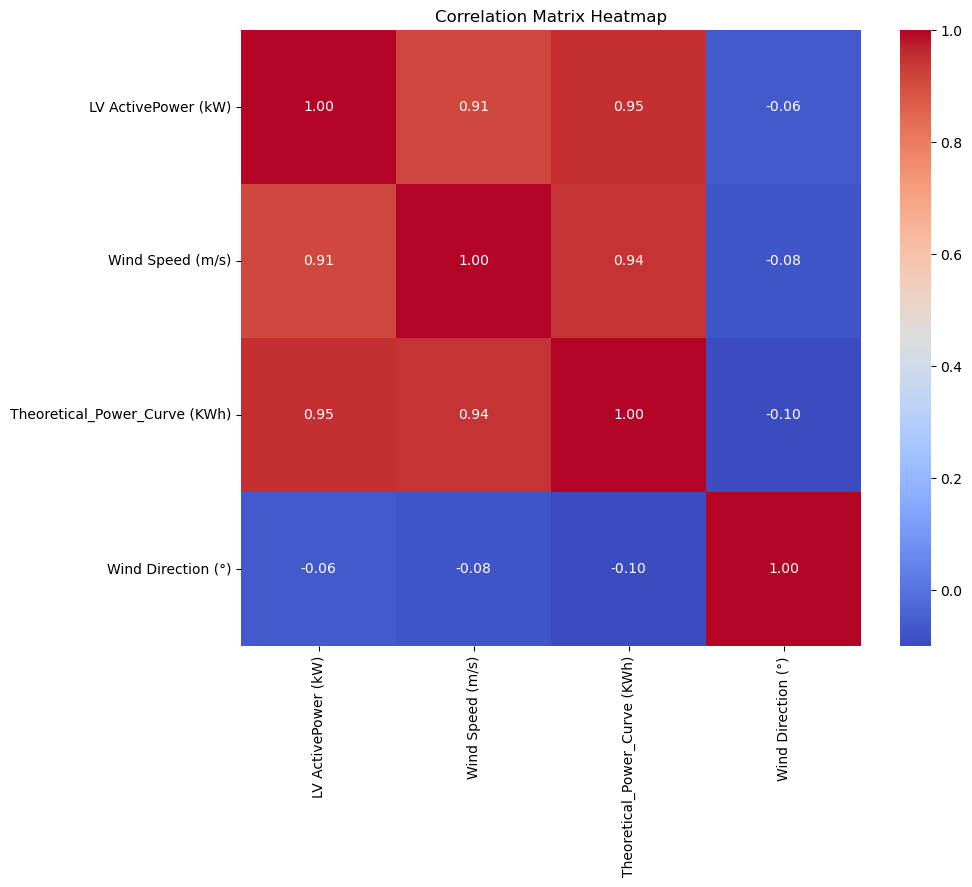

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Matrix Heatmap")
plt.show()

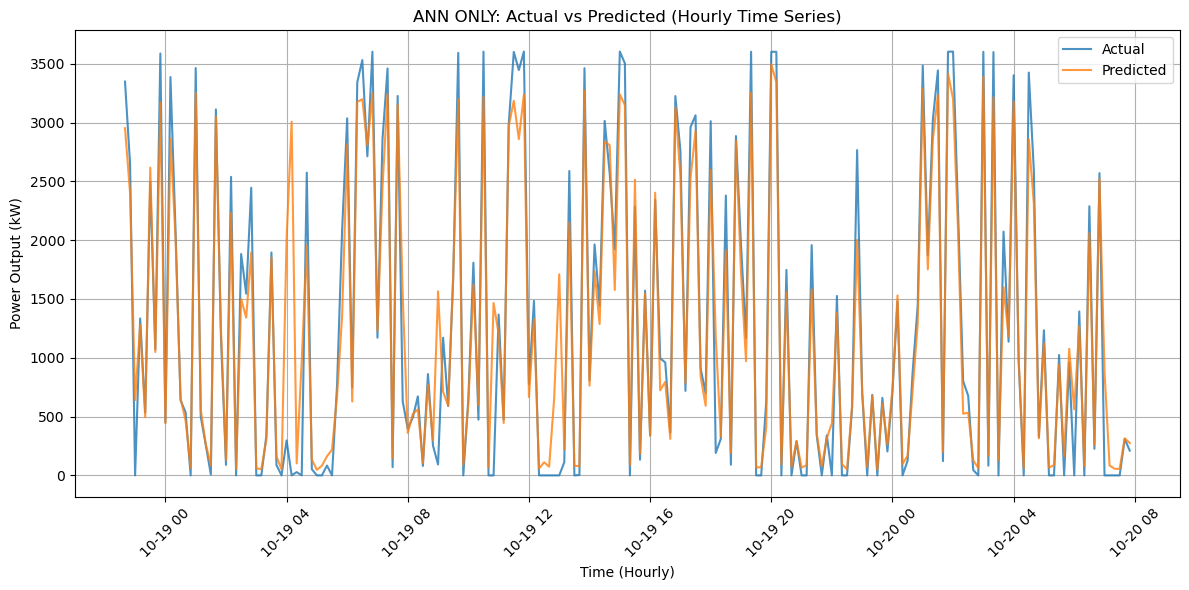

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_rescaled):][:200], y_test_rescaled[:200], label="Actual", alpha=0.8)
plt.plot(df.index[-len(y_pred_rescaled):][:200], y_pred_rescaled[:200], label="Predicted", alpha=0.8)
plt.title("ANN ONLY: Actual vs Predicted (Hourly Time Series)")
plt.xlabel("Time (Hourly)")
plt.ylabel("Power Output (kW)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
results_df = pd.DataFrame({
    'Timestamp': df.index[-len(y_test_rescaled):],  # Use the datetime index for test data
    'Actual': y_test_rescaled.flatten(),           # Flatten the arrays for tabular display
    'Predicted': y_pred_rescaled.flatten()
})

print(results_df.head(200))

# Save as CSV if needed
results_df.to_csv('predicted_vs_actual.csv', index=False)

              Timestamp       Actual    Predicted
0   2018-10-18 22:40:00  3348.910889  2952.628418
1   2018-10-18 22:50:00  2647.506104  2402.923096
2   2018-10-18 23:00:00     0.000000   639.909607
3   2018-10-18 23:10:00  1334.573975  1279.282471
4   2018-10-18 23:20:00   533.002808   496.024628
..                  ...          ...          ...
195 2018-10-20 07:10:00     0.000000    83.783791
196 2018-10-20 07:20:00     0.000000    55.813866
197 2018-10-20 07:30:00     0.000000    55.504620
198 2018-10-20 07:40:00   309.586914   314.978088
199 2018-10-20 07:50:00   210.246597   275.017303

[200 rows x 3 columns]


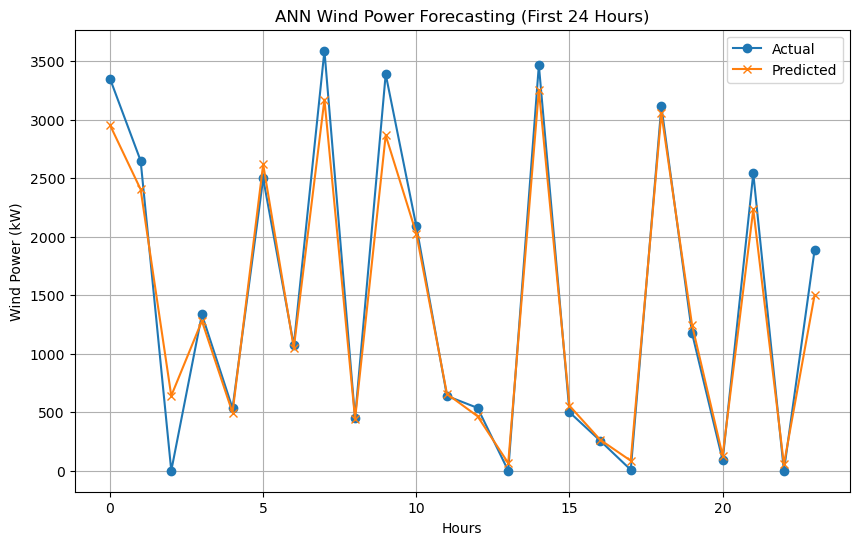

In [35]:
import matplotlib.pyplot as plt
hours = range(24)  # Horas en el eje X
plt.figure(figsize=(10, 6))
plt.plot(hours, y_test_rescaled[:24].flatten(), label='Actual', marker='o')
plt.plot(hours, y_pred_rescaled[:24].flatten(), label='Predicted', marker='x')
plt.title('ANN Wind Power Forecasting (First 24 Hours)')
plt.xlabel('Hours')
plt.ylabel('Wind Power (kW)')
plt.legend()
plt.grid(True)
plt.show()